# Récupération des données

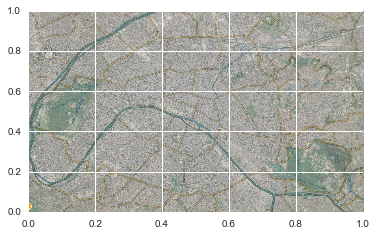

In [13]:
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.image as mpimg

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

fname="velib-enpc.npz"
with  np.load(fname) as obj:
    # Dictionnaire des informations des stations idvelib->(nom,adresse,x,y,nbre attaches,long,lat)
    stations = dict(obj['stations'].tolist())
    # Correspondance idvelib->ligne matrice
    stations_idx = dict(obj['stations_idx'].tolist())
    # Correspondance ligne matrice->idvelib
    idx_stations = dict(obj['idx_stations'].tolist())
    # Matrice du nombre de velos dispo par station par minute
    histo = obj['histo']

# Permet d'afficher la carte de Paris
def show_map():
    plt.imshow(parismap,extent=[0,1,0,1],aspect=0.6)
    
parismap = mpimg.imread("paris.jpg")
show_map()

# Estimation de densité

## Histogramme

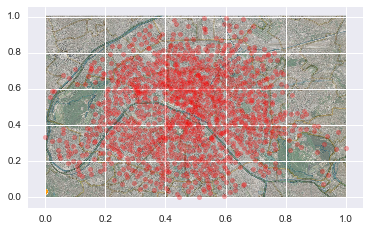

In [14]:
geo_data = np.array([ [x[2],x[3],x[4]] for x in stations.values()])
show_map()
plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")

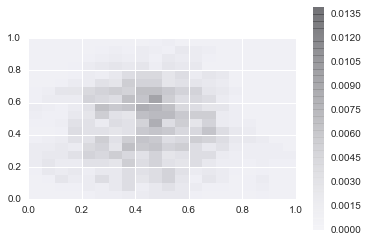

In [15]:
def histog(data, STEPS=10):
    ### Constitution du résultat
    weights = np.ones(np.shape(geo_data)[0]) # Ici on utilise des pas constants.
    weights = weights/np.sum(weights)# Normalized weights
    resultat = np.zeros((STEPS, STEPS))

    i_normed = (data[:,0]-np.min(data[:, 0]))/(np.max(data[:, 0])-np.min(data[:, 0]))
    j_normed = (data[:, 1]-np.min(data[:, 1]))/(np.max(data[:, 1])-np.min(data[:, 1]))
    ind_i = np.floor(i_normed*(STEPS-1))
    ind_j = np.floor(j_normed*(STEPS-1))
    ind_i, ind_j = ind_i.astype(int), ind_j.astype(int)
    for point in range(np.shape(i_normed)[0]):
        resultat[ind_i[point], ind_j[point]] += 1

    # Normalisation
    resultat = resultat/resultat.sum()
    return resultat
    

result = histog(geo_data, STEPS=20)
plt.imshow(result.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()
#plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.1,color="red")

On va maintenant essayer d'augmenter la taille de la grille pour avoir une estimation plus précise des densités

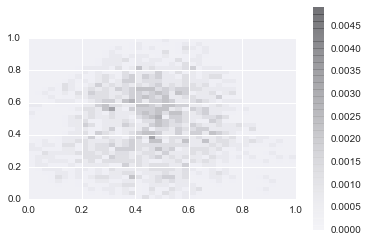

In [16]:
result_40 = histog(geo_data, 40)
plt.imshow(result_40.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()
#plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.1,color="red")

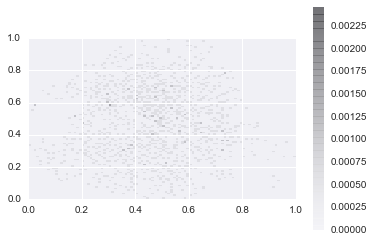

In [17]:
result_100 = histog(geo_data, 100)
plt.imshow(result_100.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()


On remarque qu'en fonction de la taille de la grille, les densités estimées fluctuent beaucoup, et que très rapidement, on peut se retrouver avec des patchs trop petits.

Dans notre modélisation, on a seulement utilisé un paramètre, le nombre d'hypercube par dimension.
L'avantage, c'est que même si cette méthode est imprécise et naïve, le nombre de paramètres reste constant même quand on passe à des dimensions supérieures.

## Fenêtres de Parzen

In [18]:
def uni(x, data, sigma): 
    """Returns 1 if all coordinates are between -0.5 and 0.5
    and 0 otherwise"""
    data_kernel = (x-data)/sigma
    result = np.zeros(np.shape(data)[0])
    indices = np.where(np.absolute(np.max(data_kernel, axis=1)) <= 0.5)
    result[indices] = 1
    return result

def gaussian(x, data, sigma):
    n, d = np.shape(data)
    data_kernel = (x-data)/sigma
    norm = np.linalg.norm(data_kernel, axis=1)
    res = np.exp((-0.5*np.square(norm))*((2*np.pi)**(d/2)))
    return res

In [19]:
def parzen(x, data, weight, sigma, kernel):
    # Normalizing weight
    wei = weight/np.sum(weight)
    n, d = np.shape(data)
    kernels = kernel(x, data, sigma)
    density = np.dot(wei.T, kernels)
    density = density/(sigma**d)
    return density

In [20]:
x = np.array([0.7, 0.5])
parzen(x, geo_data[:,:2], geo_data[:,2], 0.05, uni)

12.005224030540484

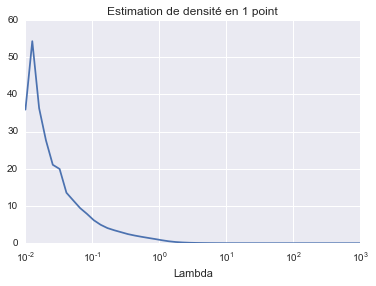

In [21]:
params = np.logspace(-2, 3, num=50)
density_x = [parzen(x, geo_data[:,:2], geo_data[:,2], sig, uni)
            for sig in params]
plt.plot(params, density_x)
plt.xscale('log')
plt.title('Estimation de densité en 1 point')
plt.xlabel("Lambda")

In [22]:
# def parzen_grid(data, weight, sigma, kernel, steps):
#     grid = np.mgrid[0:1:50j, 0:1:50j]
#     densities = np.zeros(np.shape(grid))
#     for i in np.shape(grid)[0]:
#         for j in np.shape(grid)[1]:
#             densities[i, j] = parzen(grid[i, j], data, weight, sigma, kernel)
            
            
def parzen_hist(data, sigma, kernel):
    xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
    grid = np.c_[xx.ravel(),yy.ravel()]
    pdf=np.array([parzen(g,data[:,:2],data[:,2],sigma,kernel) for g in grid]).reshape((STEPS,STEPS))
    plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower")
    plt.colorbar()
    #plt.scatter(data[:,0],data[:,1],alpha=0.15,color="red")
    #return pdf
    #plt.scatter(train_data[:,0],train_data[:,1],alpha=0.15,color="red")

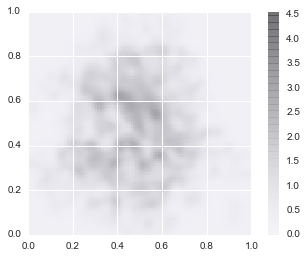

In [23]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
sigma = 0.05
STEPS=100
parzen_hist(geo_data, sigma, gaussian)


En complément, on remarque que quand on fait tendre $\sigma$ vers 0, on tend à surapprendre, et quand on tend vers l'infini à le plus apprendre, comme le suggèrent les 2 courbes suivantes:

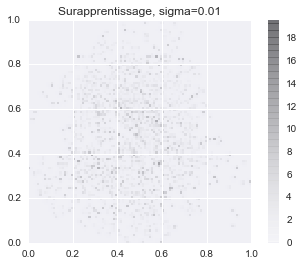

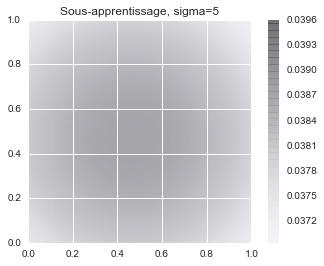

In [24]:
parzen_hist(geo_data, 0.01, gaussian)
plt.title('Surapprentissage, sigma=0.01')
plt.figure()
parzen_hist(geo_data, 5, gaussian)
plt.title('Sous-apprentissage, sigma=5')

PENSER A FAIRE ENSEMBLE DE TEST/VALIDATION POUR ESTIMATION D'ERREUR ET CONSIDERER
$L= \prod p(x_i, \theta) $

OU PLUTOT $-log(L)$

On peut difficilement appliquer l'erreur des moindres carrés comme estimateur car la densité réelle nous est inconnue.
En revanche, on pourra procéder par validation simple, en estimant la -log-vraisemblance  $-\sum_{\text{ensemble de test}} \log (p(x_i | \theta))$ sur l'ensemble de test.

In [25]:
def score(X_train, X_valid, weight, sigma, kernel):
    likelihood = 0
    for valid_point in X_valid:
        likelihood -= np.log(parzen(valid_point, X_train, weight, sigma, kernel))
    return likelihood / len(X_valid)

X_train, X_valid = train_test_split(geo_data, test_size=0.3)
weight = X_train[:,2]
X_train = X_train[:,:2]
X_valid = X_valid[:,:2]
score(X_train, X_valid, weight, 0.05, gaussian)

-0.31108404905979842

D:\Programmes\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log


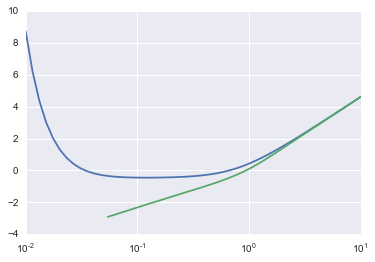

In [26]:
smgs = np.logspace(-2, 1, num=50)
scores_gauss = [score(X_train, X_valid, weight, sgm, gaussian) for sgm in smgs]
scores_uni = [score(X_train, X_valid, weight, sgm, uni) for sgm in smgs]

plt.plot(smgs, scores_gauss)
plt.plot(smgs, scores_uni)
plt.xscale('log')

PROBLEME DE SIGNE A REGLER :: VERIFIER SI NORMAL. 
FAUT-IL MULTIPLIER PAR LE PAS?

COMPARAISON DES DIFFERENTS NOYAUX A FAIRE

# Estimateur de Nadaraya-Watson et K-plus proches voisins

In [42]:
take = (-histo).copy()
for ind, line in enumerate(take):
    take[ind] = -take[ind] + geo_data[ind, 2] 

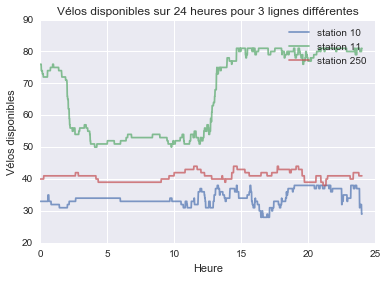

In [43]:
x = np.linspace(0,24, num=60*24)
plt.plot(x, take[5,:60*24], label='station 10', alpha=0.7)
plt.plot(x, take[11,:60*24], label='station 11', alpha=0.7)

plt.plot(x, take[250,:60*24], label='station 250', alpha=0.7)
plt.title('Vélos disponibles sur 24 heures pour 3 lignes différentes')
plt.ylabel('Vélos disponibles')
plt.xlabel('Heure')
plt.legend()

REVOIR ICI AINSI QUE PARAGRAPHE SUIVANT

REVOIR ICI AINSI QUE PARAGRAPHE SUIVANT

REVOIR ICI AINSI QUE PARAGRAPHE SUIVANT

REVOIR ICI AINSI QUE PARAGRAPHE SUIVANT
On a ici pris 3 stations aléatoirement. Le graphe ci-dessus nous permet de de réaliser deux choses.
D'une part, pour des stations différentes, les demandes peuvent être fortement différentes. En comparant la demande pour la station 11 et 250, on remarque que les demandes n'ont ni même **échelle**, ni même **comportement**.
D'autre part, on remarque que certaines stations ont quand même certains comportements communs. C'est le cas de la station 10 et 11. 

De ces observations on peut conclure qu'il n'y a a apriori aucune raison de prendre plusieurs stations à la fois sans avoir observé de comportements communs, et d'autre part que si c'est le cas, il sera nécessaire de procéder à une certaine forme de normalisation.

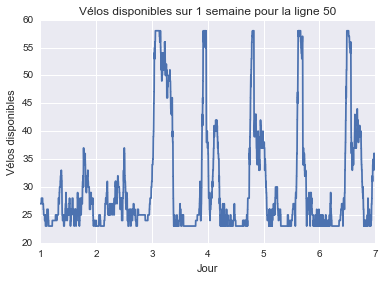

In [44]:
x_week = np.linspace(1,7, num=60*24*7)
plt.plot(x_week, take[50,:60*24*7])
plt.title('Vélos disponibles sur 1 semaine pour la ligne 50')
plt.ylabel('Vélos disponibles')
plt.xlabel('Jour')

Le graphe suivant est également très informatif. D'une part, les demandes au sein d'une journée sont très disparates. On remarque toutefois un comportement similaire pour les jours 3, 4, 5, 6 et 7 (qui correspondent très vraisemblablement aux jours de la semaine), et pour les jours 1 et 2 (qui correspondent sûrement à un week-end).

Dans une première approximation, il semble assez risqué de prendre toute l'échelle temporelle. Le plus simple, et c'est ce que nous allons faire, est dans un premier temps de ne considérer qu'une plage de 24h par semaine ...

On implémente désormais l'estimateur de Nadaraya-Watson

In [45]:
# Implémentation de l'estimateur de Nadaraya
class NWregressor:
    def __init__(self, kernel=gaussian, sigma=1):
        self.X_train = None
        self.y_train = None
        self.kernel = kernel
        self.sigma = sigma
    def fit(self, X_train, y_train):
        """A bit misleading because nothing is 'fitted' here, but we choose
        to use that name by convention"""
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, x):
        xb = np.array(x, ndmin=1)
        res = []
        for x_elem in xb:
            kernels = self.kernel(x_elem, self.X_train, self.sigma)
            res.append(np.dot(self.y_train.T, kernels)/np.sum(kernels)) 
        return res
    

In [46]:
# Variable to predict: need in bikes

# 1st approach : regression over 1 day, for 1 station
def get_one_day_of_week(stations, minutebegin, histogram):
    indices = [] # time indices to get
    time_of_day = []
    
    # Parameters
    step_day = 60*24
    N,d = np.shape(histogram)

    minutebeg = minutebegin
    minuteend = minutebegin + step_day
    one_day = [min for min in range(0, step_day)]
    while(minuteend < d):
        indices.extend([i for i in range(minutebeg, minuteend)])
        time_of_day.extend(one_day)
        minutebeg += 7*step_day
        minuteend = minutebeg+step_day
    X = time_of_day # Time (in minutes) for all days that interest us
    y = histogram[stations, indices] 
    return X,y


On veut dans un premier temps comprendre l'utilité des paramètres de la méthode, et c'est pourquoi on effectue dans un premier temps la régression sur la base de données totale et donc sans procédure de validation rigoureuse

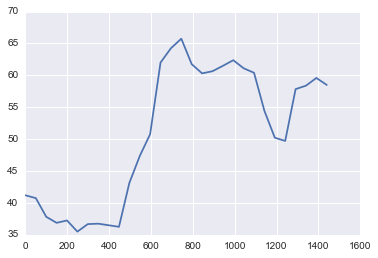

In [47]:
id0 = 100

X_id0, y_id0 = get_one_day_of_week(id0, 0, take)
X_id0 = np.reshape(X_id0, newshape=(np.shape(X_id0)[0],1))

reg = NWregressor(sigma=1)
reg.fit(X_id0, y_id0)

# Predicted day for the station
time_day = np.linspace(0, 24*60, num=30)
demand = [reg.predict(time) for time in time_day]

time_histo = [i for i in range(24*60)]
plt.plot(time_day, demand)
#plt.plot(time_histo, take[id0,:24*60])

On s'aperçoit que quand on aggrège les données sur plusieurs mêmes jours pour une même station, on obtient une très bon comportement de notre estimation vis-à-vis des demandes réelles pour un vrai jour. Ceci confirme également l'hypothèse qui a été faite: la demande pour un jour donné ne dépend pas de la date précise.

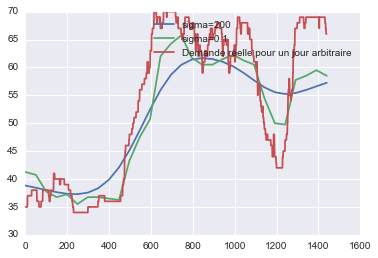

In [48]:
reg_h = NWregressor(sigma=200)
reg_h.fit(X_id0, y_id0)
demand_h = [reg_h.predict(time) for time in time_day]
reg_l = NWregressor(sigma=0.1)
reg_l.fit(X_id0, y_id0)
demand_l = [reg_l.predict(time) for time in time_day]
plt.plot(time_day, demand_h, label='sigma=200')
plt.plot(time_day, demand_l, label='sigma=0.1')
plt.plot(time_histo, take[id0,:24*60], label='Demande réelle pour un jour arbitraire')
plt.legend()

Le rôle de $\sigma$ est également similaire à celui que nous avions mis-au-jour dans la partie précédente. Plus $\sigma$ augmente, plus notre prédiction est régulière. On illustre cette observation sur la figure ci-dessus

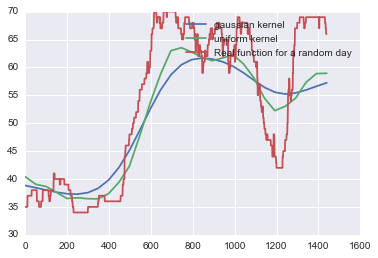

In [49]:
sgm = 200
reg_gauss = NWregressor(kernel=gaussian, sigma=sgm)
reg_gauss.fit(X_id0, y_id0)
demand_gauss = [reg_gauss.predict(time) for time in time_day]
reg_uni = NWregressor(kernel=uni, sigma=sgm)
reg_uni.fit(X_id0, y_id0)
demand_uni = [reg_uni.predict(time) for time in time_day]
plt.plot(time_day, demand_gauss, label='gaussian kernel')
plt.plot(time_day, demand_uni, label='uniform kernel')
plt.plot(time_histo, take[id0,:24*60], label='Real function for a random day')
plt.legend()

# INTERPRETATION A FAIRE

On cherche maintenant à valider notre démarche en utilisant la statistique des moindres carrés.
Comme toujours, on sépare notre base de données en ensemble d'entraînement et de validation.
A notre sens, il n'est pas pertinent de les partionner aléatoirement. Nos bases de données ont potentiellement une dépendance temporelle, et il faut en prendre compte dans notre procédure de validation.
C'est pourquoi prendre les données sur une journée complète au hasard comme base de validation semble un choix intéressant.

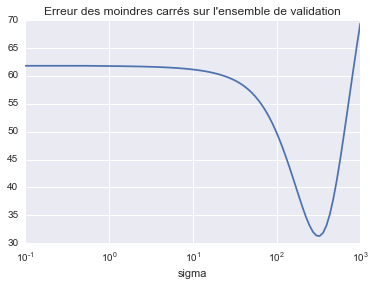

327.454916288


In [50]:
def sigma_selection(X, y, n_train, plot=False):    
    X_train, y_train = X[:n_train,:], y[:n_train]
    X_valid, y_valid = X[n_train:,:], y[n_train:]

    sgms = np.logspace(-1, 3, num=100) 
    mses = []
    for sgm in sgms:
        reg = NWregressor(sigma=sgm)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_valid)
        mses.append(mean_squared_error(y_valid, y_pred))
    indice = np.argmin(mses)
    if plot:
        plt.plot(sgms, mses)
        plt.xscale('log')
        plt.title("Erreur des moindres carrés sur l'ensemble de validation")
        plt.xlabel('sigma')
        plt.show()
    return sgms[indice]

n_train = -24*60
sigma = sigma_selection(X_id0, y_id0, n_train, plot=True)
print(sigma)

On tente désormais de prédire la demande en fonction non seulement du temps, mais également de la station considérée en utilisant le même algorithme
Pour cela, on adapte notre base de données de la manière suivante:

In [53]:
# # Ici on se ramène à une journée
# quotient = 60*24

# # Building pertinent X and y sets (for a selected part of data, because the whole dataset is too big).
# histog = np.array(histo[:50])
# nrow, ncol = np.shape(histog)
# X = np.zeros((nrow*ncol, 3))
# y = np.zeros(nrow*ncol)
# indice = 0
# for (station_n, time), need in np.ndenumerate(histog):
#     # Building y
#     y[indice] = need
#     # Building X
#     station_id = idx_stations[station_n]
#     pos_x, pos_y = stations[station_id][2], stations[station_id][3]
#     X[indice] = [pos_x, pos_y, time%quotient]
#     indice += 1
    

In [54]:
# Ici on se ramène à une journée
quotient = 60*24
duree_nvalid = 60*24*3
number_stations = 2
# Building pertinent X and y sets (for a selected part of data, because the whole dataset is too big).
histog = np.array(take[:number_stations])
nrow, ncol = np.shape(histog)
size = nrow*ncol
Xtrain = np.zeros((size - nrow*duree_nvalid, 3))
ytrain = np.zeros(size - nrow*duree_nvalid)
Xval = np.zeros((nrow*duree_nvalid, 3))
yval = np.zeros(duree_nvalid*nrow)

indice, indice_b = 0, 0
for (station_n, time), need in np.ndenumerate(histog):
    station_id = idx_stations[station_n]
    pos_x, pos_y = stations[station_id][2], stations[station_id][3]
    if time < ncol - duree_nvalid:
        ytrain[indice] = need
        Xtrain[indice] = [pos_x, pos_y, time%quotient]
        indice += 1
    else:
        yval[indice_b] = need
        Xval[indice_b] = [pos_x, pos_y, time%quotient]
        indice_b += 1

In [25]:
# NW regression with parameters (x, y, time of day)
reg = NWregressor()
reg.fit(Xtrain, ytrain)
ypred = reg.predict(Xval)

## A FINIR/COMPLETER

## Pour aller plus loin ... K-means

In [5]:
class Cluster:
    def __init__(self, cluster):
        self.cluster = np.array(cluster)
        self.prototype = None
        
    def get_prototype(self):
        self.prototype = np.mean(self.cluster, axis=0)

        

In [79]:
class Kmeans:
    def __init__(self, Xtrain, K, dist, n_iter_max=200, normalize=True):
        self.Xtrain = Xtrain.copy()
        self.n_iter_max = n_iter_max
        self.dist = dist
        self.K = K
        
        self.Xtrain_rand = Xtrain.copy()
        if normalize:
            self.Xtrain_rand = scale(self.Xtrain_rand)
        np.random.shuffle(self.Xtrain_rand)
        
        populations = np.array_split(self.Xtrain_rand, K)
        self.clusters = [Cluster(populations[i]) for i in range(K)]
        self.compute_prototypes()
        
    def compute_prototypes(self):
        for i in range(self.K):
            self.clusters[i].get_prototype()
    
    def ICD(self, X=None):
        """Returns inter-clusters distance in current state."""
        if X is None:
            X = self.Xtrain
        ptps = self.affectation(X)
        icd = 0
        for ind, x in enumerate(X):
            icd += self.dist(x, self.clusters[ptps[ind]].prototype)
        return icd / len(X)
        
    def distance_to_prototypes(self, X):
        """Returns matrix to all prototypes for all element of X"""
        Xb = np.array(X, ndmin=1)
        dists = []
        for x_elem in Xb:
            dists.append([self.dist(x_elem, clust.prototype) for clust in self.clusters])
        return np.array(dists)
    
    def affectation(self, X=None):
        """Returns table of nearest prototypes for X"""
        if X is None:
            X = self.Xtrain
        dists = self.distance_to_prototypes(X)
        nearests = np.argmax(dists, axis=1)
        return nearests
    
    def fit(self):
        """TO FINISH"""
        for ind in range(self.n_iter_max):
            while True:
                new_clusters = self.affectation()
                self.clusters = [Cluster(new_clusters[i]) for i in range(K)]
                self.compute_prototypes()
        
        

In [80]:
Xtrain = take[:50,:24*60]
L2 = lambda x, y: np.linalg.norm(x-y)

Km = Kmeans(Xtrain, 5, L2)

In [87]:
A = Km.clusters
for i in A:
    print(len(i.cluster))

10
10
10
10
10
